In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader, random_split 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.3.0+cu118
Torchvision Version: 0.18.0+cu118
Using device: cuda


### Convolution Neural Networks (CNNs)
<p>CNNs are a class of deep neural networks most commonly applied to analyzing visual imagery.</p>

In [2]:
transform_cifar = transforms.Compose([
    transforms.ToTensor(),      # Convert to tensor and scale [0,1]
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))     # Normalize to [-1,1] for 3 channels
])

In [3]:
batch = 64
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_cifar)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_cifar)


100%|██████████| 170498071/170498071 [11:29<00:00, 247330.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck')
nclasses = len(classes)

In [5]:
ninput = 3
img_size = 32

In [6]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train, val = random_split(train_dataset, [train_size, val_size])

In [10]:
len(train), len(val)

(40000, 10000)

In [11]:
# dataloaders
train_loader = DataLoader(train, batch_size=batch, shuffle=True, num_workers=2)
val_loader = DataLoader(val, batch_size=batch, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=True, num_workers=2)

In [14]:
len(train_loader), len(val_loader), len(test_loader)

(625, 157, 157)

In [15]:
def imshow_tensor(tensor_img, title=None):
    """Helper to display a PyTorch tensor image."""
    unnormalized_img = tensor_img * 0.5 + 0.5
    
    npimg = unnormalized_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose from (C, H, W) to (H, W, C)
    if title:
        plt.title(title)
    plt.axis('off')

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

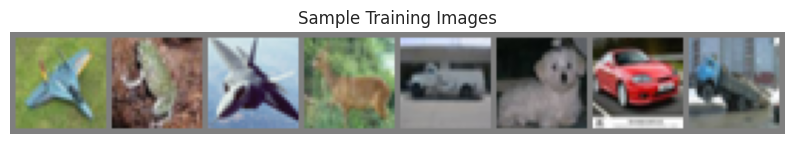

In [17]:
plt.figure(figsize=(10, 4))
imshow_tensor(torchvision.utils.make_grid(images[:8]), title="Sample Training Images")
plt.show()


### CNN Architecture 
<p><b>We will define a simple CNN</b></p>
Conv1 -> ReLU -> MaxPool1 -> Conv2 -> ReLU -> MaxPool2 -> Flatten -> FC1 -> ReLU -> FC2 (output)

In [21]:
class sCNN(nn.Module):
    def __init__(self, ninput, nclasses, img_size):
        super(sCNN, self).__init__()
        # conv layer 1
        self.conv1 = nn.Conv2d(in_channels=ninput, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv layer 2
        # input size after pool1: img_size / 2 -> 16x16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected layers
        # input size after pool2: img_size / 4 -> 8x8
        self.fc_input_size = self._get_conv_output_size(ninput, img_size)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, nclasses)     # output layer (logits)

    def _get_conv_output_size(self, ninput, img_size):
        dummy_input = torch.zeros(1, ninput, img_size, img_size)
        with torch.no_grad():
            x = self.pool1(self.relu1(self.conv1(dummy_input)))
            x = self.pool2(self.relu2(self.conv2(x)))
        return int(np.prod(x.size()[1:]))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [22]:
model = sCNN(ninput=ninput, nclasses=nclasses, img_size=img_size).to(device)

In [23]:
print(model)

sCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [24]:
# test with a dummy input batch to check shapes
dummy = torch.randn(batch, ninput, img_size, img_size).to(device)

In [26]:
with torch.no_grad():
    dummy_output = model(dummy)
dummy_output.shape      # [batch, nclasses]

torch.Size([64, 10])

In [27]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
criterion, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [34]:
epochs = 15
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(epochs):
    model.train()
    train_losses = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs_logits = model(inputs)
        loss = criterion(outputs_logits, labels)    # expect logits
        # backward pass and optimize
        loss.backward()
        optimizer.step()

        train_losses += loss.item() * inputs.size(0)  # accumulate loss 

    epoch_train_loss = train_losses / len(train_dataset)
    train_loss.append(epoch_train_loss)

    # validation phase
    model.eval()
    val_losses = 0.0
    correct_val_preds = 0
    total_val_samples = 0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_logits_val = model(inputs_val)
            loss_val = criterion(outputs_logits_val, labels_val)
            val_losses += loss_val.item() * inputs_val.size(0)

            # get predictions
            _, predicted_classes_val = torch.max(outputs_logits_val, 1)
            correct_val_preds += (predicted_classes_val == labels_val).sum().item()
            total_val_samples += labels_val.size(0)

    epoch_val_loss = val_losses / len(val)
    val_loss.append(epoch_val_loss)
    epoch_val_accuracy = correct_val_preds / total_val_samples
    val_accuracy.append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Acc: {epoch_val_accuracy:.4f}")

Epoch [1/15], Train Loss: 0.6658, Val Loss: 0.9334, Val Acc: 0.6695
Epoch [2/15], Train Loss: 0.6101, Val Loss: 0.9090, Val Acc: 0.6826
Epoch [3/15], Train Loss: 0.5598, Val Loss: 0.9179, Val Acc: 0.6770
Epoch [4/15], Train Loss: 0.5089, Val Loss: 0.9368, Val Acc: 0.6813
Epoch [5/15], Train Loss: 0.4664, Val Loss: 0.9199, Val Acc: 0.6930
Epoch [6/15], Train Loss: 0.4265, Val Loss: 1.0039, Val Acc: 0.6762
Epoch [7/15], Train Loss: 0.3877, Val Loss: 0.9875, Val Acc: 0.6883
Epoch [8/15], Train Loss: 0.3467, Val Loss: 1.0399, Val Acc: 0.6887
Epoch [9/15], Train Loss: 0.3132, Val Loss: 1.1115, Val Acc: 0.6785
Epoch [10/15], Train Loss: 0.2807, Val Loss: 1.1373, Val Acc: 0.6829
Epoch [11/15], Train Loss: 0.2449, Val Loss: 1.2155, Val Acc: 0.6817
Epoch [12/15], Train Loss: 0.2179, Val Loss: 1.2823, Val Acc: 0.6746
Epoch [13/15], Train Loss: 0.1945, Val Loss: 1.3628, Val Acc: 0.6698
Epoch [14/15], Train Loss: 0.1673, Val Loss: 1.5168, Val Acc: 0.6704
Epoch [15/15], Train Loss: 0.1512, Val Loss

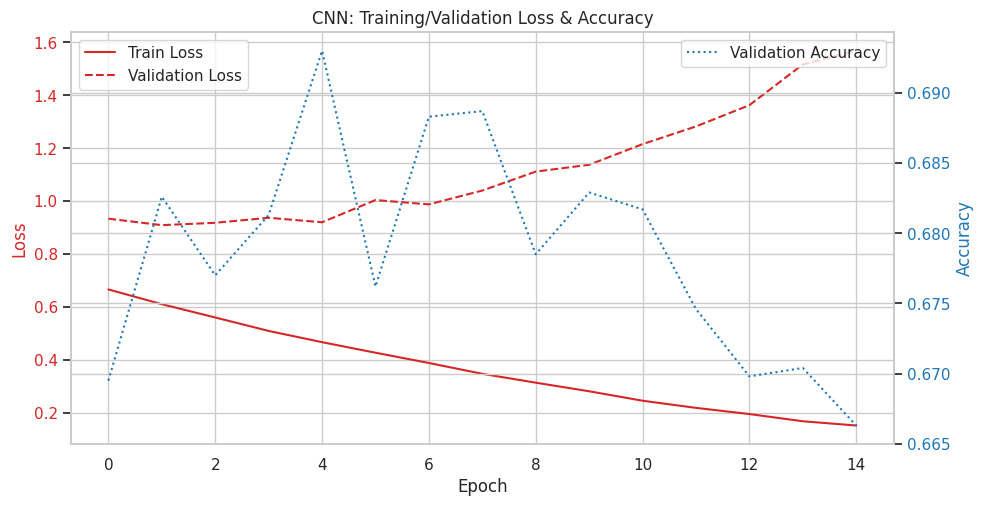

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_loss, color=color, linestyle='-', label='Train Loss')
ax1.plot(val_loss, color=color, linestyle='--', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(val_accuracy, color=color, linestyle=':', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('CNN: Training/Validation Loss & Accuracy')
plt.show()

In [43]:
# Evaluate CNN on Test set
model.eval()
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for images_test, labels_test in test_loader:
        images_test, labels_test = images_test.to(device), labels_test.to(device)
        
        outputs_logits_test = model(images_test)
        _, predicted_test = torch.max(outputs_logits_test.data, 1)
        
        test_total += labels_test.size(0)
        test_correct += (predicted_test == labels_test).sum().item()
        
        all_test_preds.extend(predicted_test.cpu().numpy())
        all_test_labels.extend(labels_test.cpu().numpy())


In [44]:
test_accuracy = test_correct / test_total 
test_accuracy * 100, test_total

(66.42, 10000)

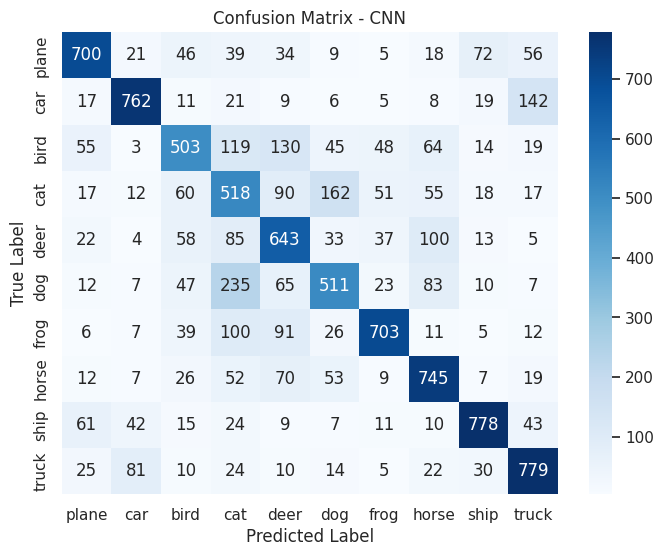


Classification Report - CNN:
               precision    recall  f1-score   support

       plane       0.76      0.70      0.73      1000
         car       0.81      0.76      0.78      1000
        bird       0.62      0.50      0.55      1000
         cat       0.43      0.52      0.47      1000
        deer       0.56      0.64      0.60      1000
         dog       0.59      0.51      0.55      1000
        frog       0.78      0.70      0.74      1000
       horse       0.67      0.74      0.70      1000
        ship       0.81      0.78      0.79      1000
       truck       0.71      0.78      0.74      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.67     10000
weighted avg       0.67      0.66      0.67     10000



In [48]:
# confusion matrix and classification report
cm = confusion_matrix(all_test_labels, all_test_preds)
report_cnn = classification_report(all_test_labels, all_test_preds, target_names=classes, zero_division=0) 

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN')
plt.show()

print("\nClassification Report - CNN:\n", report_cnn)